# Tikhonov experiment

This code attempts to learn a Tikhonov prior J(x) = 0.5*norm{(x-mu)/alpha}^{2}_{2}/.

Note: This code samples from the prior e^{-(0.5)*normsq{x-mu}/alpha^2}/sqrt(2(pi*alpha^2)). That is, it samples from the Gaussian N(mu,alpha^2).

# Import functions

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seed
np.random.seed(1)
torch.manual_seed(1)

# Define distribution

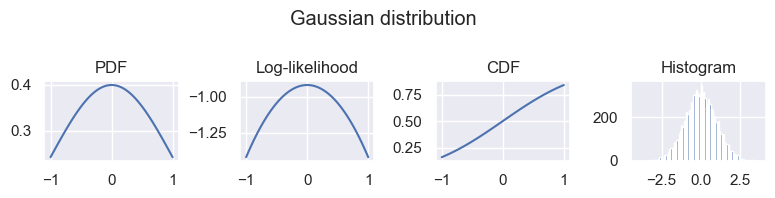

In [10]:
# Sample data points from Gaussian distribution:
# exp(-normsq{x-mu}/(0.5*alpha^2)) / sqrt(2*pi*sigma^2)

def sample_gaussian(n,mu,alpha):
    """
    Inputs:
        n       : number of points
        mu      : mean of the distribution
        alpha   : stand deviation of the distribution
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.normal.Normal(mu,alpha).sample((n,))
    return x

class GaussianSampler(object):
    def __init__(self,mu,alpha):
        self.mu = mu
        self.alpha = alpha

    def __call__(self, n):
        return sample_gaussian(n, self.mu, self.alpha)

mu = 0.0
alpha = 1.0

dist = torch.distributions.normal.Normal(mu, alpha)
x = GaussianSampler(mu,alpha)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-1, 1, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_gaussian(10000, mu, alpha), bins=100)
plt.title("Histogram")
plt.suptitle("Gaussian distribution")
plt.tight_layout()

# Define the noise function and the sampler

Text(0.5, 1.0, 'Example training points')

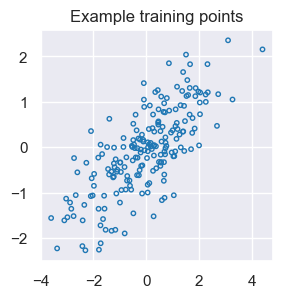

In [11]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

# parameters for Gaussian distribution
mu = 0.0
alpha = 1.0
sigma_noise = 1.0

sampler = GaussianSampler(mu,alpha)

# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")


# Plot function

In [12]:
# function to plot learned prox, convex function, original function
def prox_true(x,mu,alpha):
    val = (mu + alpha*x)/(1+alpha)
    return val

def cvx_true(x,mu,alpha):
    S = 0.5*pow(mu-x,2)/(1+alpha)
    val = 0.5*pow(x,2) - S
    return val

def prior_true(x,mu,alpha):
    val = 0.5*pow(x-mu,2)/alpha
    return val

def plot_all(model):
    xi = np.linspace(-5, 5, 100)

    # Compute the learned proximal opertor and convex function.

    prox_f  = prox(xi, model)
    cvx_f   = cvx(xi, model)
    prior_f = prior(xi,model)

    plt.rcParams["figure.figsize"] = (8, 3)

    plt.subplot(1, 3, 1)
    plt.plot(xi, prox_f, "--", ms=5, label="LPN")
    plt.plot(xi, prox_true(xi,mu,alpha),".", label="True proximal")
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # Convex function
    # Note: The convex function is equal to 0.5*y^2 - S(y,t)
    plt.subplot(1, 3, 2)
    plt.plot(xi, cvx_f - cvx_f.min(), "--", ms=5, label="Cvx func -- LPN")
    plt.plot(xi, cvx_true(xi,mu,alpha), ".", label="Cvx func at samples -- True")
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function

    plt.subplot(1, 3, 3)
    plt.plot(xi,prior_f - prior_f.min(), label="LPN")
    plt.plot(xi,prior_true(xi,mu,alpha),"--", label="Initial data J(y)")
    plt.grid("on")
    plt.legend()
    plt.title("Initial data")

    plt.tight_layout()

# Proximal matching loss

In [13]:
# Proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1

# Model parameters of the LPN

In [14]:
# Default values
beta = 10       # beta of softplus
hidden = 50     # number of hidden units
layers = 4      # number of layers

# Create a model
lpn_model = LPN(in_dim = 1, hidden=hidden, layers=layers, beta=beta).to(device)

print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


# Training function

In [15]:
# Defines what is a single iteration in the training of the LPN

def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):

    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    if not i % 500:
        print("iteration", i, "loss", loss.item())

# Train

L2 loss

iteration 0 loss 1.1202030181884766
iteration 500 loss 0.5000402927398682
iteration 1000 loss 0.5151641964912415
iteration 1500 loss 0.5134857892990112
iteration 2000 loss 0.5020198225975037
iteration 2500 loss 0.5046349763870239
iteration 3000 loss 0.49874892830848694
iteration 3500 loss 0.5063315033912659
iteration 4000 loss 0.5046128034591675
iteration 4500 loss 0.5344018340110779
iteration 0 loss 0.49515464901924133
iteration 500 loss 0.4696538746356964
iteration 1000 loss 0.5090152025222778
iteration 1500 loss 0.4946117699146271
iteration 2000 loss 0.47148311138153076
iteration 2500 loss 0.49599096179008484
iteration 3000 loss 0.5075599551200867
iteration 3500 loss 0.5142674446105957
iteration 4000 loss 0.48100897669792175
iteration 4500 loss 0.49654802680015564
mse 8.501715660095215
mse 6.305624961853027
mse 4.663791656494141
mse 3.4330239295959473
mse 2.3766510486602783
mse 1.7456328868865967
mse 1.2142032384872437
mse 1.0135977268218994
mse 0.9536252021789551
mse 0.934170067310

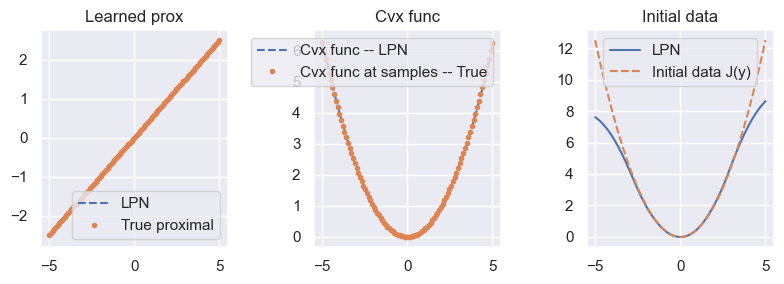

In [16]:
# initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(5000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
    
for i in range(5000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)


L1 loss

iteration 0 loss 0.9876294136047363
iteration 500 loss 0.5587490797042847
iteration 1000 loss 0.5431714057922363
iteration 1500 loss 0.568539559841156
iteration 2000 loss 0.5714543461799622
iteration 2500 loss 0.5695186853408813
iteration 3000 loss 0.5485344529151917
iteration 3500 loss 0.5644831657409668
iteration 4000 loss 0.5498419404029846
iteration 4500 loss 0.5713708400726318
iteration 0 loss 0.5488093495368958
iteration 500 loss 0.5686777830123901
iteration 1000 loss 0.5571329593658447
iteration 1500 loss 0.5460900664329529
iteration 2000 loss 0.5636882185935974
iteration 2500 loss 0.5423197746276855
iteration 3000 loss 0.5621840953826904
iteration 3500 loss 0.5589427351951599
iteration 4000 loss 0.5616508722305298
iteration 4500 loss 0.5648854374885559
mse 8.502191543579102
mse 6.3749871253967285
mse 4.69333553314209
mse 3.4649786949157715
mse 2.401991844177246
mse 1.7028231620788574
mse 1.2532879114151
mse 1.1290186643600464
mse 1.101904034614563
mse 1.092573642730713
final ms

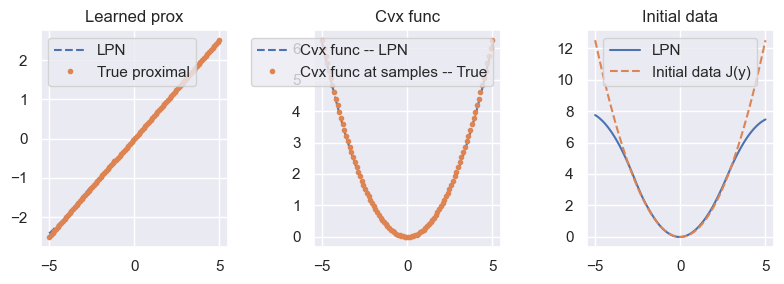

In [17]:
# initialize
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(5000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
    
for i in range(5000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

# Proximal matching loss

Proximal matching loss with a decreasing sequence of gamma parameters, starting from gamma = 0.5

iteration 0 loss 0.7371097207069397
iteration 500 loss 0.5606465339660645
iteration 1000 loss 0.5479969382286072
iteration 1500 loss 0.557744026184082
iteration 0 loss 0.546046257019043
iteration 500 loss 0.5636762976646423
iteration 1000 loss 0.5680473446846008
iteration 1500 loss 0.5505760312080383
mse 8.5017728805542
mse 6.269659519195557
mse 4.657533168792725
mse 3.4728310108184814
mse 2.495776653289795
mse 1.7119349241256714
mse 1.5063889026641846
mse 1.4683270454406738
mse 1.4532408714294434
mse 1.4442027807235718
final mse 1.4376341104507446
(100,) (100,) (100,) (100,)


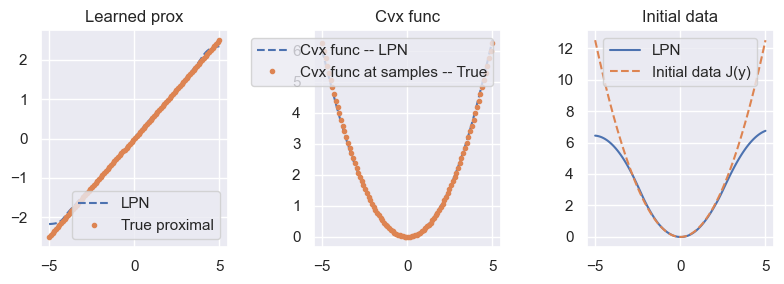

In [18]:
lpn_model = LPN(in_dim=1, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

bsize = 2000
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

iteration 0 loss 0.6145200133323669
iteration 500 loss 0.6326440572738647
iteration 1000 loss 0.626787543296814
iteration 1500 loss 0.6302027106285095
iteration 2000 loss 0.6430128216743469
iteration 2500 loss 0.6223393082618713
iteration 3000 loss 0.6289448142051697
iteration 3500 loss 0.6278451085090637
mse 8.501705169677734
mse 6.322976112365723
mse 4.6535186767578125
mse 3.462362766265869
mse 2.590108871459961
mse 1.922012448310852
mse 1.5868171453475952
mse 1.4185874462127686
mse 1.3726184368133545
mse 1.3555103540420532
final mse 1.3470966815948486
(100,) (100,) (100,) (100,)


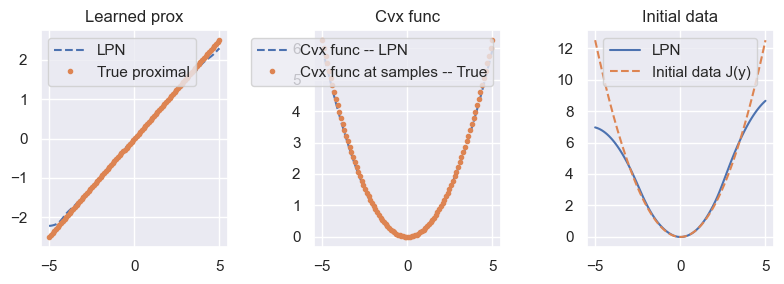

In [19]:
gamma_loss = 0.4

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

iteration 0 loss 0.6989288330078125
iteration 500 loss 0.715916633605957
iteration 1000 loss 0.712422251701355
iteration 1500 loss 0.7043389081954956
iteration 2000 loss 0.7099517583847046
iteration 2500 loss 0.7032038569450378
iteration 3000 loss 0.714027464389801
iteration 3500 loss 0.7039653062820435
mse 8.502948760986328
mse 6.215597629547119
mse 4.495502471923828
mse 3.1929378509521484
mse 2.2156379222869873
mse 1.6798456907272339
mse 1.2864145040512085
mse 1.1829127073287964
mse 1.149898886680603
mse 1.1334396600723267
final mse 1.1234816312789917
(100,) (100,) (100,) (100,)


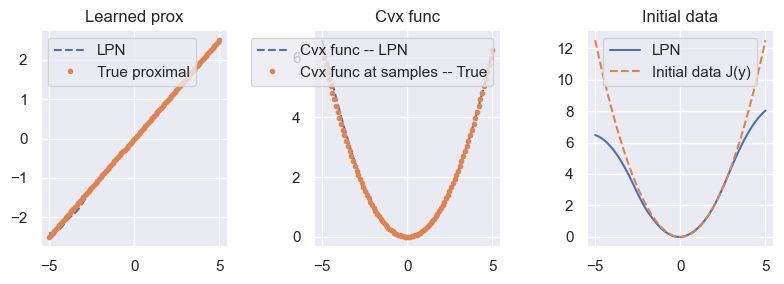

In [20]:
gamma_loss = 0.3

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

iteration 0 loss 0.7964998483657837
iteration 500 loss 0.7940986156463623
iteration 1000 loss 0.8041972517967224
iteration 1500 loss 0.8109134435653687
iteration 2000 loss 0.8022338151931763
iteration 2500 loss 0.8110659122467041
iteration 3000 loss 0.805864155292511
iteration 3500 loss 0.8017433881759644
mse 8.501710891723633
mse 6.285330295562744
mse 4.584500312805176
mse 3.346889019012451
mse 2.357236862182617
mse 1.7813149690628052
mse 1.3695342540740967
mse 1.2673877477645874
mse 1.234372854232788
mse 1.218096137046814
final mse 1.208327293395996
(100,) (100,) (100,) (100,)


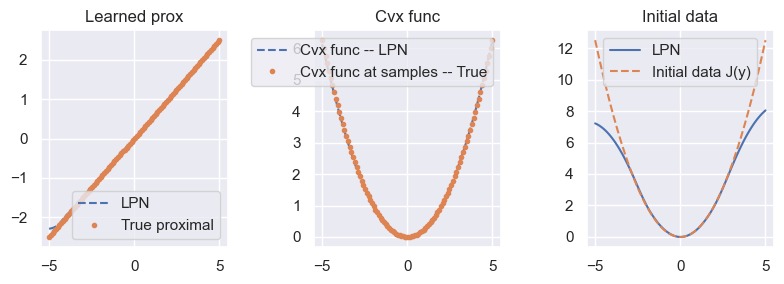

In [21]:
gamma_loss = 0.2

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.1

iteration 0 loss 0.8996962308883667
iteration 500 loss 0.8967516422271729
iteration 1000 loss 0.8987277150154114
iteration 1500 loss 0.9043062925338745
iteration 2000 loss 0.9038990139961243
iteration 2500 loss 0.9087730646133423
iteration 3000 loss 0.9031198620796204
iteration 3500 loss 0.9025188088417053
mse 8.501713752746582
mse 6.232397079467773
mse 4.540347099304199
mse 3.2554171085357666
mse 2.225376844406128
mse 1.656852126121521
mse 1.2597935199737549
mse 1.1670249700546265
mse 1.1382842063903809
mse 1.1249133348464966
final mse 1.117132306098938
(100,) (100,) (100,) (100,)


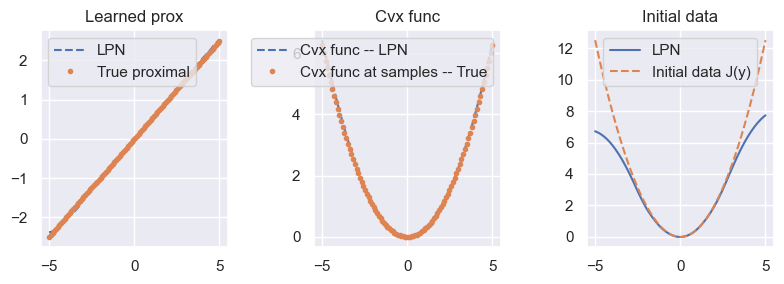

In [22]:
gamma_loss = 0.1

for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.05

iteration 0 loss 0.9478570222854614
iteration 500 loss 0.9473223686218262
iteration 1000 loss 0.9516209959983826
iteration 1500 loss 0.9462285041809082
mse 8.501683235168457
mse 6.248171329498291
mse 4.57353401184082
mse 3.294555425643921
mse 2.2748756408691406
mse 1.7181881666183472
mse 1.3034329414367676
mse 1.2032196521759033
mse 1.1723304986953735
mse 1.157982349395752
final mse 1.1496834754943848
(100,) (100,) (100,) (100,)


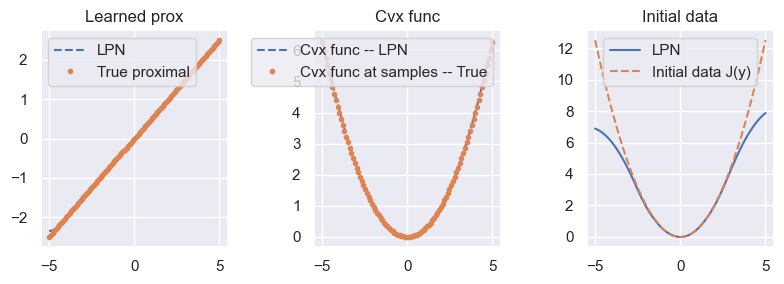

In [23]:
gamma_loss = 0.05

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)